# Atividade Prática Supervisionada - APS
## Ciência das Redes - CAIA012 PPGCA / CAIA0022 CPGEI

# Criação e Análise de Rede de Capacidade de Transporte Público em Curitiba

## Discentes: Brendon Leonam Pasquim e Bruno Walter

# Sumário

1. [Objetivos](#1.-Objetivos)
1. [Considerações Iniciais / Metodologia](#2.-Considerações-Iniciais-/-Metodologia)
1. [Input de dados e definição de funções](#3.-Input-de-dados-e-definição-de-funções)
1. [Métricas da Rede](#4.-Métricas-da-Rede)
1. [Topologia da Rede](#5.-Topologia-da-Rede)
1. [Visualizações com Gephi](#6.-Visualizações-com-Gephi)
1. [Considerações Finais](#7.-Considerações-Finais)

# 1. Objetivos
1. Construir uma rede de terminais e pontos de ônibus, interligando-os 
através de Linhas de ônibus que por eles atravessam.
2. Ranquear os terminais de integração, baseando-se nas métricas de 
centralidade de redes.
3. Produzir visualizações do grafo que contribuam para compreensão de 
características da rede.

# 2. Considerações Iniciais / Metodologia

A cidade de Curitiba possui 23 terminais, 6900 pontos de ônibus e 400 linhas de ônibus. Estes números expressivos não consideram a infraestrutura metropolitana, que agrega em cobertura e disponbilidade, mas também em complexidade.

Com o objetivo de viabilizar a construção da rede proposta, decidiu-se considerar apenas terminais e linhas municipais de Curitiba, bem como um subcojunto de terminais. Os terminais escolhidos foram:

1. Terminal Boqueirão
2. Terminal Cabral
3. Terminal Campina do Siqueira
4. Terminal Capão da Imbuia
5. Terminal Pinheirinho
6. Terminal Portão

Estes terminais foram escolhidos de forma arbitrária, baseando se no itinerário das linhas que por ele percorriam, bem como no conhecimento prévio dos autores em relação aos mesmos.

A partir destes terminais o script implementado (exposto na seção xyz) identificou as linhas que por eles passavam, bem como os pontos de ônibus utilizados por estas linhas.

Os terminais e pontos de ônibus são identificados como nós na rede. As arestas representam por quais pontos ou terminais dada linha passa. Pontos e terminais podem estar presentem em mais de uma linha de ônibus, ou seja, são reutilizados. A capacidade de transporte de passageiros dos ônibus que percorrem uma linha é representada como o peso da aresta.

Nesse sentido, notou-se que contruir a rede reutilizando os pontos tornaria a análise de capacidade de transporte mais ônerosa, visto que, ao construir a rede as capacidades iriam se sobrepor (a aresta que conecta o ponto teria que armazenar um peso para cada linha).

Por isso, decidiu-se que apenas terminais de integração seriam reutilizados. Pontos de ônibus seriam plotados de acordo com a linha e, mesmo que na vida real representassem o mesmo ponto físico, seriam plotados uma vez para cada linha que os utilizassem. Desta forma, foi possível garantir que cada aresta apresentasse apenas um peso.

# 3. Input de dados e definição de funções

Nesta seção são apresentadas as funções e os requisitos necessários para a construção da rede de capacidades.

## 3.1 Parâmetros de Entrada

1. Arquivo CSV contendo as linhas e pontos de ônibus. Este arquivo foi obtido do portal da C3SL da UFPR (https://dadosabertos.c3sl.ufpr.br/). O arquivo escolhido foi aquele gerado em 08/03/2022 (2022_03_08_pontosLinha.csv);

2. Terminais de Integração a serem plotados (definidos na variável "terminais").

## 3.2 Dependências
As bibliotecas utilizadas foram:
1. NetworkX para criação de redes complexas;
2. Pandas para manipulação e filtragem de dados;
3. Matplotlib para plotagem de gráficos.

## 3.3 Dados de Saída
1. Rede NetworkX do tipo DiGraph (Grafo com arestas direcionadas);
2. Arquivo GML "Todos_Terminais-Directed.gml". Utilizado posteriormente no software Gephi.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

todos_pontos_linha = pd.read_csv("2022_03_08_pontosLinha.csv")

tipo_linhas_cabral = None
tipo_linhas_portao = None
tipo_linhas_pinheirinho = None
tipo_linhas_boqueirao = None
tipo_linhas_campina_do_siqueira = None
tipo_linhas_capao_da_imbuia = None
todos_tipos = None

def get_pontos_linha(codigo_linha: str, id_itineratio: int) -> pd.core.frame.DataFrame:
    return todos_pontos_linha.query("COD == @codigo_linha and ITINERARY_ID == @id_itineratio").sort_values("SEQ")

def add_pontos_no_grafo(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    for row in pontos_linha.itertuples(index=False):
        NOME = getattr(row, 'NOME')
        NUM = getattr(row, 'NUM')
        SEQ = getattr(row, 'SEQ')
        SENTIDO = getattr(row, 'SENTIDO')
        ITINERARY_ID = getattr(row, 'ITINERARY_ID')
        COD = getattr(row, 'COD')
        #Esse linha garante que os terminais não são duplicados.
        #Para isso a informação referente a linha, que consta no nome do ponto, é removida.
        ID = get_id_ponto(NOME, COD, NUM)
        NOME = ID if 'Terminal' in NOME else NOME
        if 'Terminal' in NOME:
            NOME = ID
            #Codigo arbitrário para facilitar a identificação de terminais.
            COD = str(999)

        grafo.add_node(ID, nome=NOME, num=NUM, seq=SEQ, sentido=SENTIDO, itinerario_id=ITINERARY_ID, cod=COD)            

def add_arestas_entre_pontos(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    #Os indices das linhas do dataframe não são sequenciais, visto que, o dataframe é resultado
    #de uma query.
    indexes = pontos_linha.index.values.tolist()
    capacidade_linha = get_capacidade_por_codigo_linha(pontos_linha.loc[indexes[0], 'COD'])
    for i in range(len(pontos_linha)-1):
        source = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i]])
        target = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i+1]])
        grafo.add_edge(source, target, weight=capacidade_linha)

def get_linhas_por_terminal(nome_terminal: str) -> pd.core.frame.DataFrame:
    nome_terminal = f"{nome_terminal} -"
    codigos_linha = todos_pontos_linha.query("NOME.str.contains(@nome_terminal)", engine="python").groupby("COD")
    return list(codigos_linha.groups.keys())

# Função mantida como referência. Ver função "get_itinerario_com_terminal".
def get_itinerarios_por_linha(codigo_linha: str) -> list:
    return list(todos_pontos_linha.query("COD == @codigo_linha").sort_values("ITINERARY_ID").groupby("ITINERARY_ID").groups.keys())

# Esta função garante que o itinerário retornado contém pelo menos um terminal. A função "get_itinerarios_por_linha" não tem
# essa restrição.
def get_itinerario_com_terminal(codigo_linha: str) -> list:
    terminal = 'Terminal '
    return list(todos_pontos_linha.query("COD == @codigo_linha and NOME.str.contains(@terminal)", engine="python").sort_values("ITINERARY_ID").groupby("ITINERARY_ID").groups.keys())

def get_id_ponto(nome_ponto: str = None, codigo_ponto: str = None, numero_ponto: int = 0, ponto_info: pd.core.series.Series = None) -> str:
    if ponto_info is not None:
        nome_ponto = ponto_info['NOME']
        codigo_ponto = ponto_info['COD']
        numero_ponto = ponto_info['NUM']

    ID = None
    if 'Terminal' in nome_ponto:
        ID = nome_ponto.split('-')[0].strip()
    else:
        ID = f"{codigo_ponto}-{str(numero_ponto)}"
        
    return ID

def get_capacidade_por_tipo_linha(tipo_linha: str) -> int:
    tipo_linha = tipo_linha.upper() if tipo_linha is not None else None
    # Capacidade de acordo com a categoria do veículo.
    # Fonte: https://www.urbs.curitiba.pr.gov.br/transporte/rede-integrada-de-transporte/42
    # Cada linha pode apresentar diferentes modelos de veículos utilizados. Comentários foram adicionados indicando o modelo escolhido.
    capacidade = {
        'LIGEIRÃO': 250,
        'EXPRESSO': 250,#Biarticulado
        'LINHA DIRETA': 110,#Padron
        'INTERBAIRROS': 140,#Articulado
        'ALIMENTADOR': 85,#Comum
        'TRONCAL': 85,#Comum
        'CONVENCIONAL': 85#Comum
    }
    
    return capacidade[tipo_linha]

def get_capacidade_por_codigo_linha(codigo_linha: str) -> str:
    tipo = todos_tipos[codigo_linha]
    return get_capacidade_por_tipo_linha(tipo)

# Esta função cria o mapeamento entre o código e o tipo da linha de ônibus.
def set_tipo_linhas() -> None:
    # Para quase todos os dados abaixo a fonte foi https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/Linhas_x_Empresas_Operadoras_codigo.pdf
    # As exceções estão sinalizadas com comentários

    global tipo_linhas_cabral, tipo_linhas_portao, tipo_linhas_pinheirinho, tipo_linhas_boqueirao, tipo_linhas_campina_do_siqueira, tipo_linhas_capao_da_imbuia
    global todos_tipos

    tipo_linhas_cabral = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '200':'LIGEIRÃO',
        '202':'EXPRESSO',
        '203':'EXPRESSO',
        '207':'TRONCAL',
        '210':'LINHA DIRETA',
        '211':'ALIMENTADOR',
        '212':'ALIMENTADOR',
        '213':'ALIMENTADOR',
        '214':'ALIMENTADOR',
        '216':'ALIMENTADOR',
        '245':'ALIMENTADOR',
        '607':'LINHA DIRETA',
        '700':'LINHA DIRETA'
    }

    tipo_linhas_portao = {
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '024':'LINHA DIRETA', 
        '050':'INTERBAIRROS', 
        '216':'ALIMENTADOR', 
        '611':'ALIMENTADOR', 
        '612':'ALIMENTADOR', 
        '615':'ALIMENTADOR', 
        '616':'ALIMENTADOR', 
        '700':'LINHA DIRETA', 
        'X35':'LINHA DIRETA'
    }


    tipo_linhas_pinheirinho = {
        '040':'INTERBAIRROS',
        '060':'INTERBAIRROS',
        '350':'EXPRESSO',
        '502':'EXPRESSO',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '550':'LIGEIRÃO',
        '600':'ALIMENTADOR',
        '602':'EXPRESSO',
        '603':'EXPRESSO',
        '610':'LINHA DIRETA',
        '617':'ALIMENTADOR',
        '630':'ALIMENTADOR',
        '631':'ALIMENTADOR',
        '633':'ALIMENTADOR',
        '635':'ALIMENTADOR',
        '636':'ALIMENTADOR',
        '637':'ALIMENTADOR',
        '638':'ALIMENTADOR',
        '639':'ALIMENTADOR',
        '640':'ALIMENTADOR',
        '641':'ALIMENTADOR',
        '642':'ALIMENTADOR',
        '643':'ALIMENTADOR',
        '644':'ALIMENTADOR',
        '646':'ALIMENTADOR',
        '649':'ALIMENTADOR',
        '650':'ALIMENTADOR',
        '655':'ALIMENTADOR',
        '659':'ALIMENTADOR',
        '680':'ALIMENTADOR',
        '681':'ALIMENTADOR',
        '690':'ALIMENTADOR',
        '700':'LINHA DIRETA',
        '772':'ALIMENTADOR',
        'X11':'EXPRESSO',
        'X20':'EXPRESSO',
        'X35':'LINHA DIRETA'
    }

    ## As linhas 539 . Optou-se por deixá-las todas como 'ALIMENTADOR'. 

    tipo_linhas_boqueirao = {
        '335':'ALIMENTADOR',
        '500':'LIGEIRÃO',
        '502':'EXPRESSO',
        '503':'EXPRESSO',
        '505':'LINHA DIRETA',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '513':'ALIMENTADOR',
        '515':'ALIMENTADOR',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '531':'ALIMENTADOR',
        '532':'ALIMENTADOR',
        '533':'ALIMENTADOR',
        '534':'ALIMENTADOR',
        '535':'ALIMENTADOR',
        '536':'ALIMENTADOR',
        '539':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        '545':'ALIMENTADOR',
        '546':'LINHA DIRETA',
        '602':'EXPRESSO',
        'X12':'EXPRESSO'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/expressos.pdf

    ## As linhas X02 e X31 não possuem caracterização do tipo de transporte. Optou-se por deixá-las todas como 'ALIMENTADOR'. 
    tipo_linhas_campina_do_siqueira = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '024':'LINHA DIRETA',
        '027':'INTERBAIRROS',
        '303':'EXPRESSO',
        '304':'LINHA DIRETA',
        '801':'TRONCAL',
        '811':'ALIMENTADOR',
        '812':'ALIMENTADOR',
        '814':'ALIMENTADOR',
        '816':'ALIMENTADOR',
        'X02':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        'X31':'ALIMENTADOR'# Informação não disponível. Trata-se de suposição.
    }

    tipo_linhas_capao_da_imbuia = {
        '020':'INTERBAIRROS', 
        '021':'INTERBAIRROS', 
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '302':'EXPRESSO', 
        '303':'EXPRESSO', 
        '304':'LINHA DIRETA', 
        '311':'ALIMENTADOR', 
        'X30':'LINHA DIRETA'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
    
    todos_tipos = tipo_linhas_cabral | tipo_linhas_portao | tipo_linhas_pinheirinho | tipo_linhas_boqueirao | tipo_linhas_campina_do_siqueira | tipo_linhas_capao_da_imbuia

def add_terminais_e_linhas(grafo: nx.classes.graph.Graph, terminais: list) -> None:
    for terminal in terminais:
        linhas = get_linhas_por_terminal(terminal)
        for codigo_linha in linhas:
            id_itinerario = get_itinerario_com_terminal(codigo_linha)[-1]#get_itinerarios_por_linha(codigo_linha)[-1]
            pontos = get_pontos_linha(codigo_linha, id_itinerario)
            add_pontos_no_grafo(grafo, pontos)
            add_arestas_entre_pontos(grafo, pontos)
    
set_tipo_linhas()

In [2]:
# DiGraph representa grafos direcionados.
grafo = nx.DiGraph()
terminais = [
    'Terminal Boqueirão',
    'Terminal Cabral',
    'Terminal Campina do Siqueira',
    'Terminal Capão da Imbuia',
    'Terminal Pinheirinho',
    'Terminal Portão']
add_terminais_e_linhas(grafo, terminais)

In [5]:
# Exporta a rede gerada para o formato GML. Este arquivo foi utilizado para gerar as visualizações com o software Gephi.
nx.write_gml(grafo, 'Todos_Terminais-Directed.gml')

# 4. Métricas da Rede

### Número de nós

In [7]:
grafo.number_of_nodes()

1988

### Número de edges

In [8]:
print(grafo.number_of_edges())

2086


### Centralidade de grau

In [9]:
# Calculando a centralidade de grau
degree_centrality = nx.degree_centrality(grafo)

# Colocando degree_centrality em ordem decrescente
degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de grau de cada nó
degree_centrality

[('Terminal Pinheirinho', 0.02415702063412179),
 ('Terminal Portão', 0.014091595369904378),
 ('Terminal Capão Raso', 0.013588324106693507),
 ('Terminal Boqueirão', 0.012078510317060896),
 ('Terminal Campina do Siqueira', 0.011575239053850024),
 ('Terminal Cabral', 0.011575239053850024),
 ('Terminal Hauer', 0.010065425264217413),
 ('Terminal Sítio Cercado', 0.009562154001006542),
 ('Terminal Capão da Imbuia', 0.008555611474584801),
 ('Terminal Carmo', 0.006039255158530448),
 ('Terminal Campo Comprido', 0.0035228988424760945),
 ('Terminal Boa Vista', 0.003019627579265224),
 ('Terminal CIC', 0.003019627579265224),
 ('Terminal Fazendinha', 0.0025163563160543532),
 ('Terminal Oficinas', 0.0025163563160543532),
 ('Terminal Guadalupe', 0.0020130850528434826),
 ('Terminal Centenário', 0.001509813789632612),
 ('Terminal Santa Cândida', 0.001509813789632612),
 ('814-190138', 0.001509813789632612),
 ('Terminal Tatuquara', 0.001509813789632612),
 ('335-140480', 0.0010065425264217413),
 ('335-14048

### Centralidade de intermediação

In [10]:
# Calculando a centralidade de intermediação
betweenness_centrality = nx.betweenness_centrality(grafo)

# Colocando betweenness centrality em ordem decrescente
betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de intermediação de cada nó
betweenness_centrality

[('Terminal Pinheirinho', 0.35290831323373856),
 ('Terminal Portão', 0.24818275825426928),
 ('Terminal Capão Raso', 0.1858644380821721),
 ('Terminal Campina do Siqueira', 0.17341513054052793),
 ('Terminal Hauer', 0.14406395008305847),
 ('Terminal Cabral', 0.12248142635083732),
 ('Terminal Sítio Cercado', 0.11182845427132507),
 ('Terminal Boqueirão', 0.10958313630744855),
 ('Terminal Capão da Imbuia', 0.08868420159029664),
 ('022-109077', 0.06849688297870356),
 ('Terminal Carmo', 0.05618280319221574),
 ('Terminal Fazendinha', 0.05368758967528613),
 ('023-109067', 0.042761459050798936),
 ('024-109067', 0.042761459050798936),
 ('507-109006', 0.04074465732531676),
 ('023-109077', 0.03952387396222495),
 ('Terminal Campo Comprido', 0.03841485263477457),
 ('507-109076', 0.03762417276581087),
 ('022-109034', 0.037287687187261),
 ('022-109065', 0.037232443916676926),
 ('023-109012', 0.036080951157346455),
 ('023-109069', 0.03602570788676238),
 ('023-109047', 0.03597046461617831),
 ('617-150331'

### Centralidade de proximidade

In [11]:
# Calculando a centralidade de proximidade
closeness_centrality = nx.closeness_centrality(grafo)

# Colocando closeness centrality em ordem decrescente
closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de proximidade de cada nó
closeness_centrality

[('Terminal Capão Raso', 0.053349912176243165),
 ('Terminal Pinheirinho', 0.05329973984504293),
 ('Terminal Portão', 0.05323507341573698),
 ('Terminal Hauer', 0.05017741481649312),
 ('528-150331', 0.05017741481649312),
 ('617-150331', 0.050168161429775225),
 ('020-170002', 0.05016076117732403),
 ('060-170983', 0.050158911455324716),
 ('021-150169', 0.05015336310775767),
 ('Terminal CIC', 0.05014596722011044),
 ('607-109071', 0.05013857351341722),
 ('350-108203', 0.050133061661336145),
 ('550-108203', 0.050133061661336145),
 ('600-150331', 0.050133061661336145),
 ('641-150331', 0.050133061661336145),
 ('642-150331', 0.050133061661336145),
 ('646-150331', 0.050133061661336145),
 ('655-150331', 0.050133061661336145),
 ('690-150331', 0.050133061661336145),
 ('772-150331', 0.050133061661336145),
 ('507-109002', 0.0501330296640681),
 ('602-108057', 0.050127487040556314),
 ('502-108056', 0.05012563977172375),
 ('202-108056', 0.05012563977172375),
 ('603-108056', 0.05012563977172375),
 ('X20-1

### Centralidade de autovetor

In [12]:
# Calculando a centralidade de autovetor
eigenvector_centrality = nx.eigenvector_centrality(grafo)

# Colocando betweenness centrality em ordem decrescente
eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de autovetor
eigenvector_centrality

[('Terminal Capão Raso', 0.29881395094933444),
 ('Terminal Portão', 0.28470830394487123),
 ('Terminal Pinheirinho', 0.26031419340396744),
 ('Terminal Sítio Cercado', 0.14210691400289513),
 ('Terminal CIC', 0.1186468920998957),
 ('502-108056', 0.11848792800489215),
 ('507-109002', 0.11848792800489215),
 ('602-108057', 0.11848792800489215),
 ('020-170002', 0.11848792800489215),
 ('021-150169', 0.11848792800489215),
 ('023-109077', 0.11848792800489215),
 ('202-108056', 0.11848792800489215),
 ('607-109071', 0.11848792800489215),
 ('603-108056', 0.11848792800489215),
 ('X20-108056', 0.11848792800489215),
 ('Terminal Boqueirão', 0.11587703394250144),
 ('502-108122', 0.11288973228982815),
 ('602-108052', 0.11288973228982815),
 ('022-109066', 0.11288973228982815),
 ('202-108049', 0.11288973228982815),
 ('203-108052', 0.11288973228982815),
 ('216-150023', 0.11288973228982815),
 ('700-109002', 0.11288973228982815),
 ('024-109066', 0.11288973228982815),
 ('603-108049', 0.11288973228982815),
 ('05

### Coeficiente de clusterização

In [13]:
# Exibindo o coeficiente de clusterização
print(nx.average_clustering(nx.Graph(grafo)))

3.85628524024115e-06


### Distribuição de graus

Text(0, 0.5, 'Numero de nós')

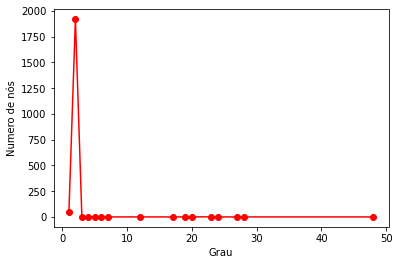

In [14]:
dicDegree = dict(grafo.degree() )
valores = sorted(set(dicDegree.values()))
valores

hist = [list(dicDegree.values()).count(x) for x in valores]


plt.plot(valores, hist, 'ro-') 

plt.xlabel('Grau')
plt.ylabel('Numero de nós')

# 5. Topologia da Rede

In [ ]:
nx.draw(grafo, with_labels=False)

### Circular Layout

In [ ]:
# No layout circular, todos os nós são colocados na circunferência de um círculo. 
# As conexões de cada nó para outros nós conectados são indicadas pelas linhas que conectam esses pontos.
# Isso ajuda a mostrar a distribuição de densidade das conexões e a distância entre os nós de conexão.


plt.figure(figsize=(10,10))
pos = nx.circular_layout(grafo)
nx.draw_networkx(grafo, pos, with_labels=False, edge_color='.4')
 
plt.axis('off')
plt.tight_layout();

### Random Layout

In [ ]:
# Neste layout os nós são colocados aleatoriamente dentro de uma área.
# As conexões entre os nós são desenhadas com linhas. O layout ajuda a entender a distribuição aleatória da rede.

plt.figure(figsize=(50,50))
pos = nx.random_layout(grafo)
nx.draw_networkx(grafo, pos, with_labels=False)
 
plt.axis('off')
plt.tight_layout();

### Spring Layout

In [ ]:
# O Spring Layout ajuda a entender se existem nós isolados no gráfico. 
# Também dá pistas sobre o número de componentes conectados.
# O alphaparâmetro mostra a opacidade da cor do nó.

plt.figure(figsize=(10,10))
nx.draw_networkx(grafo, alpha=0.7, with_labels=False)
plt.axis('off')
plt.tight_layout();

# 6. Visualizações com Gephi

## 6.1 Terminais, pontos e linhas.
Essa imagem apresenta todos os terminais, pontos e linhas identificadas pelo script de criação da rede.
Nela nota-se:
1. Terminais de integração identificados como nós vermelhos grandes.
2. Pontos de ônibus identificados por nós de tamanhos menores do que dos terminais. Nós da mesma cor fazem parte da mesma linha/itinerário de ônibus.
3. Linhas de ônibus identificados por arestas entre os nós. Nessa visualização não são considerados o peso das arestas nem direção.

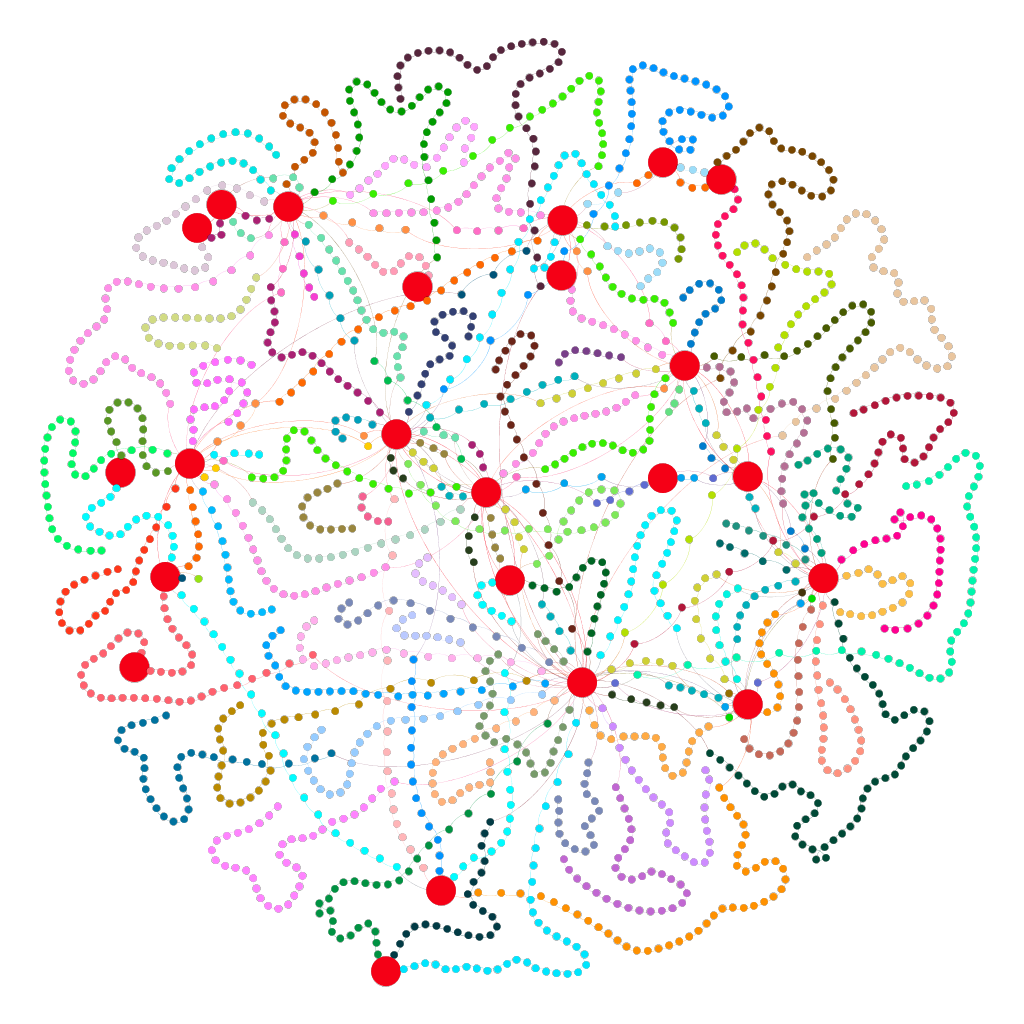

## 6.2 Rede de Capacidades

Essa imagem apresenta os terminais, pontos e linhas de ônibus destacando:
1. Terminais de integração como nós na cor vermelha. O tamanho dos nós é variável e proporcional ao grau total do nó.
2. Pontos de ônibus como nós. Nós da mesma cor fazem parte da mesma linha/itinerário de ônibus.
3. Linhas de ônibus como arestas direcionadas. A espessura da aresta é proporcional a capacidade de transporte de passageiros do tipo de ônibus que percorre a linha. Essa capacidade foi definida na seção 3.

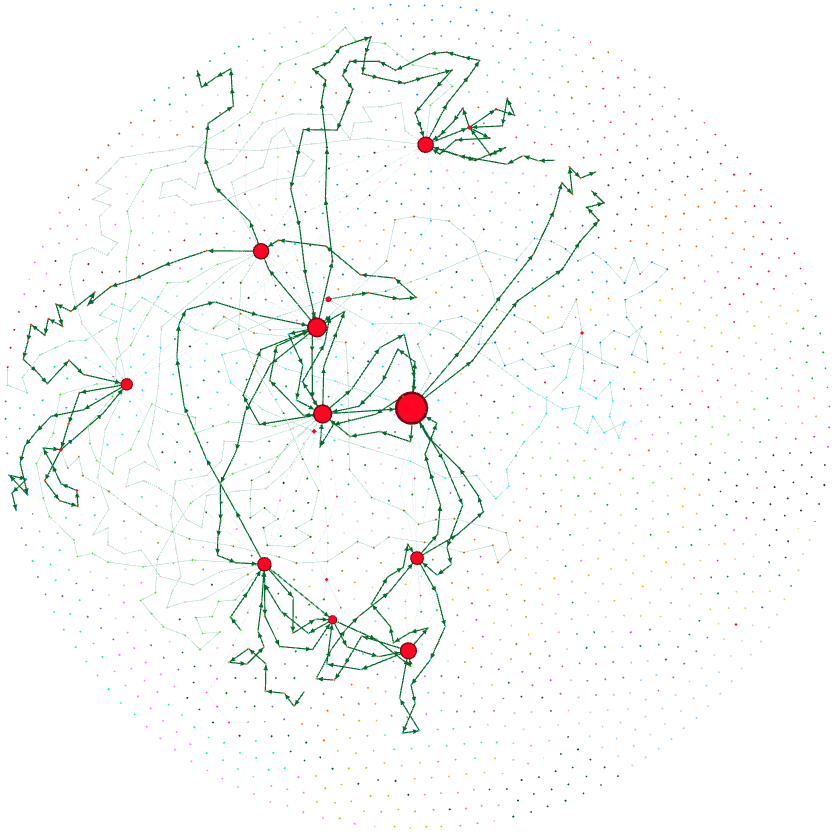

# 7. Considerações Finais
O atual trabalho teve como objetivo construir uma rede de capacidade de transporte dos ônibus públicos da cidade de Curitiba. Para isso, se coletou e tratou os dados públicos abertos fornecidos pelo IPPUC e URBS. Nestes dados, identificou-se os terminais de integração e pontos de ônibus, bem como as linhas de ônibus que os interligavam.

Com os dados tratados, construiu-se uma rede em que Terminais e Pontos de ônibus são nós e as linhas de ônibus são arestas. Cada aresta tem um peso que representa a capacidade de pessoas que podem ser transportadas nesta linha. É importante notar que, o peso atribuído a aresta representa a capacidade do tipo de ônibus que percorre a linha, e não a capacidade total de transporte em um dado momento.